In [2]:
import numpy as np
import xarray as xr
import xroms
import matplotlib
import matplotlib.pyplot as plt



import sys
sys.path.append('/home/mk7641/storage/Utils/')
from Utils_2 import *

In [2]:
pwd

'/storagenas1/mk7641/ACCESS/ProductionTests/InitConfigs/Config1'

This configuration restarts from slice 84 in the 6 month daily restart file from the high resolution model. This corresponds to day 7285.

In [3]:
rst = xr.open_dataset('/storagenas1/mk7641/ACCESS/TESTS/PHYSICS_HIRES/CROCO_FILES/run5/croco_rst_3.nc')
his = xroms.open_netcdf('/storagenas1/mk7641/ACCESS/TESTS/PHYSICS_HIRES/CROCO_FILES/run5/croco_his_3.nc')

#select the 85th time step in the history file and 84th time step in the restart file
his = his.isel(time=slice(85,86))
rst = rst.isel(time=slice(84,85))
grid = xr.open_dataset('/storagenas1/mk7641/ACCESS/TESTS/PHYSICS_HIRES/CROCO_FILES/generated_files/croco_grd.nc')

print(his.time.values/86400, rst.time.values/86400)
zlevs = his.z_rho[0,:,0,0].values
zlevs



[7285.] [7285.]


array([-1931.5043  , -1777.614   , -1608.5242  , -1433.4854  ,
       -1260.8112  , -1096.9406  ,  -946.1667  ,  -810.81476 ,
        -691.63934 ,  -588.2759  ,  -499.649   ,  -424.296   ,
        -360.6018  ,  -306.95425 ,  -261.83807 ,  -223.8847  ,
        -191.89203 ,  -164.82555 ,  -141.80852 ,  -122.10669 ,
        -105.11082 ,   -90.31921 ,   -77.32143 ,   -65.78367 ,
         -55.436047,   -46.061832,   -37.488426,   -29.580019,
         -22.231617,   -15.36442 ,    -8.922263,    -2.869067],
      dtype=float32)

In [4]:
def find_closest_z_index(z_levs, depth):
    return np.argmin(np.abs(z_levs + depth))
z_levs = his.z_rho.values[-1, :, 0, 0]

def scale_values(arr,vmin,vmax):
    old_min, old_max = np.min(arr), np.max(arr)  # Original min and max
    scaled = (arr - old_min) / (old_max - old_min)  # Normalize to [0,1]
    scaled = scaled * (vmax - vmin) + vmin
    return scaled

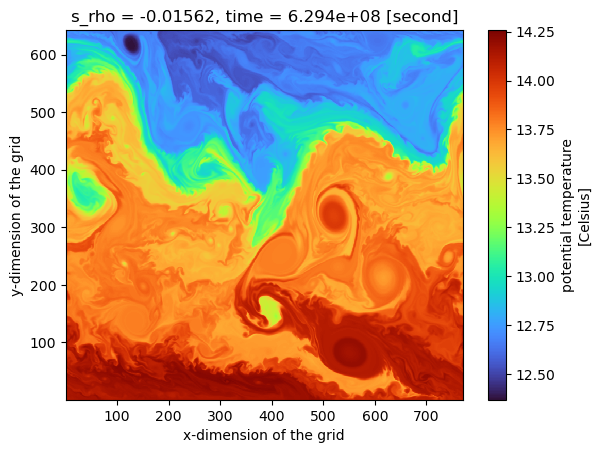

In [5]:
rst.temp[-1,-1,:,:].plot(cmap="turbo")
plt.axvline(490, color='black', alpha=0.)
# plt.axvline(520, color='black', alpha=0.5, label='slice index')
plt.axvline(550, color='black', alpha=0.)
plt.axhline(290, color='black', alpha=0.)
# plt.axhline(320, color='black', alpha=0.)
plt.axhline(348, color='black', alpha=0.)

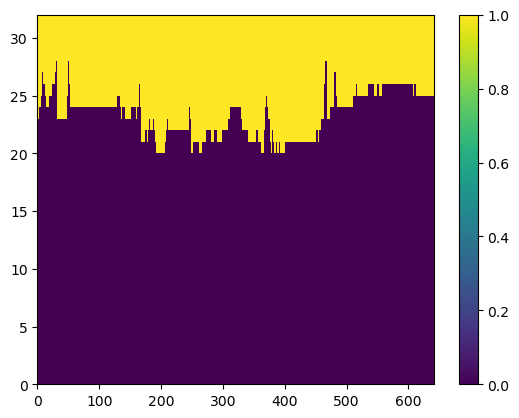

In [6]:
z_rho = his.z_rho.values

def mask_below_hbl(hbl, z_levs):
    hbl_expanded = np.expand_dims(hbl, axis=1)  # Shape: (time, 1, lat, lon)
    mask = (-z_levs) < hbl_expanded  # zlevs is negative, hbl is positive
    return mask
    

plt.pcolormesh(mask_below_hbl(his.hbl.values,z_rho)[0,:,:,520])
plt.colorbar()
     
    
    

Text(0.5, 1.0, 'Plankton field at depth')

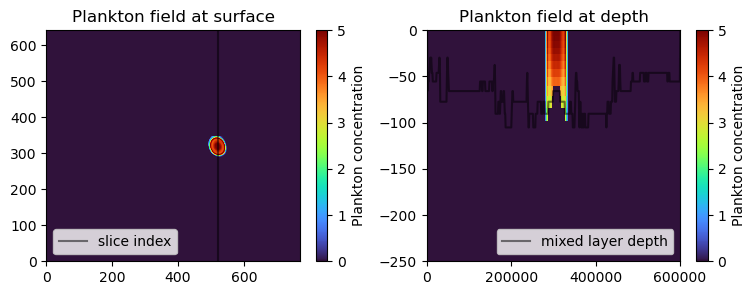

In [7]:
desired_temperature = 13.96
sigma = 0.05

surface_temp= his.temp[-1, -1, :, :].values
gaussian_mask = np.exp(-0.5 * ((surface_temp - desired_temperature) / sigma)**2)
vortex_mask = np.zeros_like(gaussian_mask)
vortex_mask[290:348, 490:550] = 1

surface_plankton = surface_temp * gaussian_mask * vortex_mask

#make copies of the surface in depth that decay by the inverse square law by distance from the surface

first_100m_depths = z_levs[z_levs >= -110]
#normalize the depths to be between 0 and 1
first_100m_depths = np.abs((first_100m_depths - first_100m_depths[-1]) / (first_100m_depths[0] - first_100m_depths[-1]))
#make n copies of the surface plankton field
n = first_100m_depths.size
stacked_plankton = np.tile(surface_plankton, (n, 1, 1))
#make this decay by the inverse square law over depth
depth_multiplier = 1 / (1 + first_100m_depths**2)
stacked_plankton *= depth_multiplier[:, None, None]
final_plankton_field = np.zeros_like(his.temp.values)
final_plankton_field[-1,-n:, :, :] = stacked_plankton

hbl_mask = mask_below_hbl(his.hbl.values, his.z_rho.values)

final_plankton_field *= hbl_mask

vmin=0
vmax=5
final_plankton_field = scale_values(final_plankton_field, vmin,vmax)


fig, ax = plt.subplots(1, 2, figsize=(9, 3))

im=ax[0].pcolormesh(final_plankton_field[-1,-1], cmap='turbo', vmin=vmin,vmax=vmax)
# ax[0].axvline(490, color='black', alpha=0.1)
ax[0].axvline(520, color='black', alpha=0.5, label='slice index')
# ax[0].axvline(550, color='black', alpha=0.1)
# ax[0].axhline(290, color='black', alpha=0.1)
# ax[0].axhline(320, color='black', alpha=0.1)
# ax[0].axhline(348, color='black', alpha=0.1)
ax[0].legend(loc='lower left')
plt.colorbar(im, ax=ax[0], label='Plankton concentration')
ax[0].set_title('Plankton field at surface')

X = grid.y_rho.values[:,520]
Z = zlevs
X, Z = np.meshgrid(X, Z)
hbl = his.hbl.values[-1, :, 520]
im=ax[1].pcolormesh(X,Z,final_plankton_field[-1,:,:,520], cmap='turbo', vmin=vmin,vmax=vmax)
#plot the hbl values
ax[1].plot(grid.y_rho.values[:,520], -hbl, color='black', alpha=0.5, label='mixed layer depth')

ax[1].set_ylim(-250,0)
plt.colorbar(im, ax=ax[1], label='Plankton concentration')
ax[1].legend(loc='lower right')
ax[1].set_title('Plankton field at depth')


NameError: name 'nutrient_field' is not defined

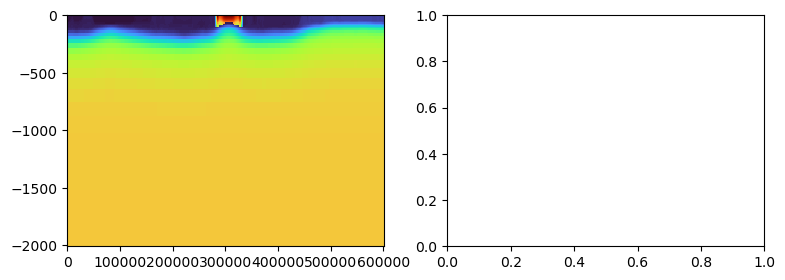

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].pcolormesh(X,Z,his.rho[-1,:,:,520] + final_plankton_field[-1,:,:,520] , cmap='turbo')
ax[1].pcolormesh(X,Z,nutrient_field[-1,:,:,520], cmap='turbo')
ax[0].set_ylim(-300,0)
ax[1].set_ylim(-300,0)

plt.show()


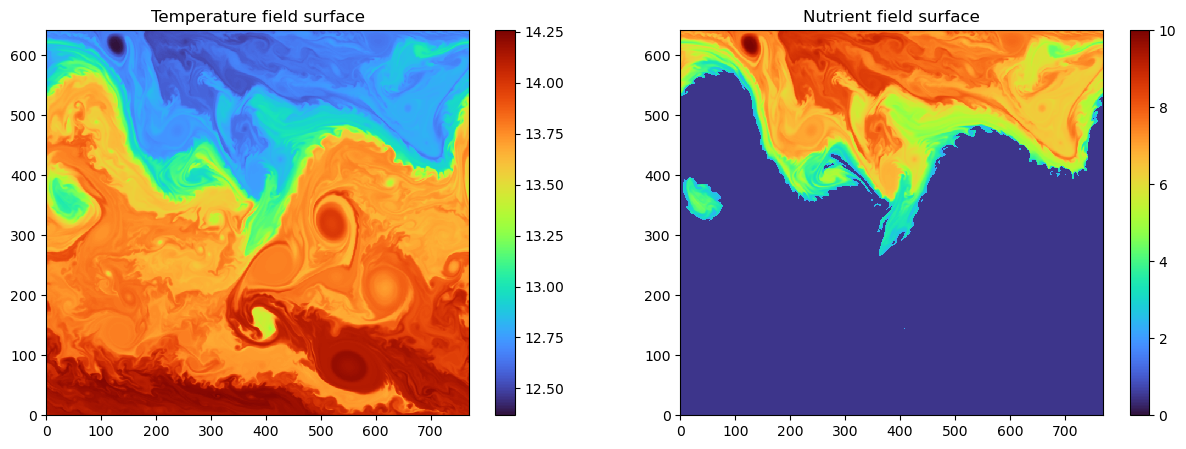

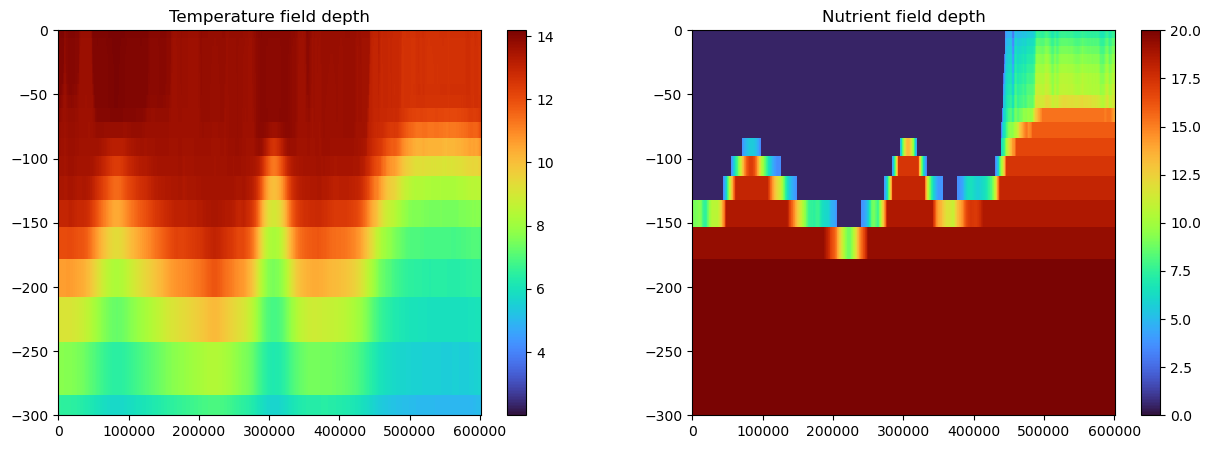

In [9]:
temp_range = (12.3683195, 13.5)
sigma=0.1
temp = his.temp.values


# gaussian_mask = np.exp(-0.5 * ((temp - 12.5) / sigma)**2)

jet_mask = (temp < 13.3).astype(np.uint8)  # 1 for cold, 0 for warm
# Apply scaling only to the cold region
scaled_cold_region = (temp - temp_range[1]) / (temp_range[0] - temp_range[1])

# Clip values to ensure they stay within [0,1] range
scaled_cold_region = np.clip(scaled_cold_region, 0, 1)

#vertical gradient with same shape as temp
vert_decay_scale = np.ones_like(temp)
#for index [-16:] in the vertical dimension, have a linear gradient from 1 to 0.5
vert_decay_scale[:,-16:] = np.linspace(1, 0.5, 16).reshape(1,16,1,1)

# Apply the mask (keep only cold regions)
scaled_map = jet_mask * scaled_cold_region
 
nutrient_field = jet_mask * scaled_cold_region * 20 * vert_decay_scale

# rescale the nutrient at each depth level to be between 0.5 and the maximum value at that depth
for i in range(nutrient_field.shape[1]):
    if np.max(nutrient_field[:,i]) == np.min(nutrient_field[:,i]):
        continue
    nutrient_field[:,i] = scale_values(nutrient_field[:,i], 0.5, np.max(nutrient_field[:,i]))


fig, ax = plt.subplots(1,2, figsize=(15,5))
im=ax[0].pcolormesh(temp[-1,-1], cmap='turbo')
ax[0].set_title('Temperature field surface')
plt.colorbar(im, ax=ax[0])
im=ax[1].pcolormesh(nutrient_field[-1,-1], cmap='turbo',vmin=0, vmax=10)
ax[1].set_title('Nutrient field surface')
plt.colorbar(im, ax=ax[1])
plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5))
im=ax[0].pcolormesh(X,Z,temp[-1,:,:,520], cmap='turbo')
ax[0].set_title('Temperature field depth')
ax[0].set_ylim(-300,0)
plt.colorbar(im, ax=ax[0])
im=ax[1].pcolormesh(X,Z,nutrient_field[-1,:,:,520], cmap='turbo',vmin=0, vmax=20)
ax[1].set_title('Nutrient field depth')
plt.colorbar(im, ax=ax[1])
ax[1].set_ylim(-300,0)

plt.show()

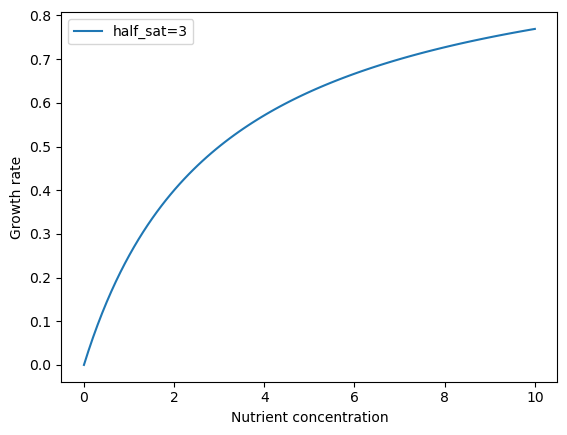

In [10]:
def monod(vals, half_sat):
    return vals / (vals + half_sat)

half_sat = 0.5

x = np.linspace(0, 10, 100)
y = monod(x, 3)


plt.plot(x, y, label="half_sat=3")

plt.xlabel("Nutrient concentration")
plt.ylabel("Growth rate")
plt.legend()


In [11]:
hbl = his.hbl
plankton = final_plankton_field
nutrient = nutrient_field

print(hbl.shape, plankton.shape, nutrient.shape)

(1, 642, 770) (1, 32, 642, 770) (1, 32, 642, 770)


In [12]:
#import a bio restart file for the correct attributes
bio_rst = xr.open_dataset('/storagenas1/mk7641/ACCESS/TESTS/BIO/CROCO_FILES/RESTART_FILES/RESTART_BIO_EDITED.nc')

print(bio_rst['PHYTO'].dims)
print(bio_rst['NO3'].dims)
print(bio_rst['hbl'].dims)


('time', 's_rho', 'eta_rho', 'xi_rho')
('time', 's_rho', 'eta_rho', 'xi_rho')
('time', 'eta_rho', 'xi_rho')


In [13]:
(rst.temp.values[...,0]==rst.temp.values[...,-2]).all()

True

In [14]:
def check_bc(data):
    #must be periodic in the last dimension
    is_periodic = np.all(data[...,0] == data[...,-2]) and np.all(data[...,1] == data[...,-1])
    #must have no-flux boundary conditions in the second last dimension
    is_no_flux = np.all(data[...,0,:] == data[...,1,:]) and np.all(data[...,-1,:] == data[...,-2,:])
    return is_periodic and is_no_flux

check_bc(his.hbl.values)

False

In [15]:
config1_bio = rst.copy(deep=True)
#keep type as float64 for exact restart
config1_bio['PHYTO'] = (('time', 's_rho', 'eta_rho', 'xi_rho'), plankton.astype(np.float64))
config1_bio['NO3'] = (('time', 's_rho', 'eta_rho', 'xi_rho'), nutrient.astype(np.float64))
config1_bio['hbl'] = (('time', 'eta_rho', 'xi_rho'), hbl.values.astype(np.float64))

#copy attributes
config1_bio['PHYTO'].attrs = bio_rst['PHYTO'].attrs
config1_bio['NO3'].attrs = bio_rst['NO3'].attrs
config1_bio['hbl'].attrs = bio_rst['hbl'].attrs

#edit the attrs of the dataset
config1_bio.attrs['title'] = 'Config 1: Bio restart file sourced from croco_rst_3.nc. Added plankton in vortex and nutrient field in the north side of the jet.'

print("BC good phyto: ", check_bc(config1_bio['PHYTO'].values))
print("BC good nutrient: ", check_bc(config1_bio['NO3'].values))

BC good phyto:  True
BC good nutrient:  True


In [16]:
config1_bio

<xarray.Dataset>
Dimensions:     (xi_rho: 770, xi_u: 769, eta_rho: 642, eta_v: 641, s_rho: 32,
                 s_w: 33, time: 1, auxil: 4)
Coordinates: (12/13)
  * xi_rho      (xi_rho) float64 1.0 2.0 3.0 4.0 5.0 ... 767.0 768.0 769.0 770.0
  * xi_u        (xi_u) float64 1.5 2.5 3.5 4.5 5.5 ... 766.5 767.5 768.5 769.5
  * eta_rho     (eta_rho) float64 1.0 2.0 3.0 4.0 ... 639.0 640.0 641.0 642.0
  * eta_v       (eta_v) float64 1.5 2.5 3.5 4.5 5.5 ... 638.5 639.5 640.5 641.5
  * s_rho       (s_rho) float64 -0.9844 -0.9531 -0.9219 ... -0.04688 -0.01562
  * s_w         (s_w) float64 -1.0 -0.9688 -0.9375 ... -0.0625 -0.03125 0.0
    ...          ...
    lat_rho     (eta_rho, xi_rho) float64 ...
    lon_u       (eta_rho, xi_u) float64 ...
    lat_u       (eta_rho, xi_u) float64 ...
    lon_v       (eta_v, xi_rho) float64 ...
    lat_v       (eta_v, xi_rho) float64 ...
  * time        (time) float64 6.294e+08
Dimensions without coordinates: auxil
Data variables: (12/32)
    spherical   |S1 ...
    xl          float64 ...
    el          float64 ...
    Vtransform  float64 ...
    sc_r        (s_rho) float64 ...
    sc_w        (s_w) float64 ...
    ...          ...
    AKv         (time, s_w, eta_rho, xi_rho) float64 ...
    AKt         (time, s_w, eta_rho, xi_rho) float64 ...
    AKs         (time, s_w, eta_rho, xi_rho) float64 ...
    PHYTO       (time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    NO3         (time, s_rho, eta_rho, xi_rho) float64 20.0 20.0 ... 7.441 7.361
    hbl         (time, eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/53)
    type:           CROCO restart file
    title:          Config 1: Bio restart file sourced from croco_rst_3.nc. A...
    date:           
    rst_file:       CROCO_FILES/run5/croco_rst_3.nc
    his_file:       CROCO_FILES/run5/croco_his_3.nc
    avg_file:       CROCO_FILES/run5/croco_avg_3.nc
    ...             ...
    rho0_expl:      Mean density used in Boussinesq approximation
    rho0_units:     kilogram meter-3
    gamma2:         1.0
    gamma2_expl:    Slipperiness parameter
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL CAPSTONE MPI EW_PERIODIC CURVGRID SPHERICAL MASK...

In [17]:
#save the bio file
config1_bio.to_netcdf('hires_bio_rst.nc')


## Coarsening this rst file

In [18]:
import xarray as xr

In [19]:
from CoarsenDataset import coarsen_dataset

In [20]:
config1_bio = xr.open_dataset('hires_bio_rst.nc')

In [49]:
config1_bio_medres = coarsen_dataset(config1_bio, 4)

In [50]:
config1_bio_medres

<xarray.Dataset>
Dimensions:     (eta_rho: 162, xi_rho: 194, time: 1, s_rho: 32, s_w: 33,
                 xi_u: 193, eta_v: 161, auxil: 4)
Coordinates: (12/13)
    lon_rho     (eta_rho, xi_rho) float64 -175.0 -175.0 -174.9 ... -165.4 -165.3
    lat_rho     (eta_rho, xi_rho) float64 44.99 44.99 44.99 ... 50.42 50.42
  * eta_rho     (eta_rho) float64 0.0 1.0 2.0 3.0 ... 158.0 159.0 160.0 161.0
  * xi_rho      (xi_rho) float64 0.0 1.0 2.0 3.0 4.0 ... 190.0 191.0 192.0 193.0
    lon_u       (eta_rho, xi_u) float64 -175.0 -174.9 -174.9 ... -165.4 -165.4
    lat_u       (eta_rho, xi_u) float64 44.99 44.99 44.99 ... 50.42 50.42 50.42
    ...          ...
    lon_v       (eta_v, xi_rho) float64 -175.0 -175.0 -174.9 ... -165.4 -165.3
    lat_v       (eta_v, xi_rho) float64 45.0 45.0 45.0 45.0 ... 50.4 50.4 50.4
  * eta_v       (eta_v) float64 0.5 1.5 2.5 3.5 4.5 ... 157.5 158.5 159.5 160.5
  * s_rho       (s_rho) float64 -0.9844 -0.9531 -0.9219 ... -0.04688 -0.01562
  * s_w         (s_w) float64 -1.0 -0.9688 -0.9375 ... -0.0625 -0.03125 0.0
  * time        (time) float64 6.294e+08
Dimensions without coordinates: auxil
Data variables: (12/32)
    h           (eta_rho, xi_rho) float64 2e+03 2e+03 2e+03 ... 2e+03 2e+03
    f           (eta_rho, xi_rho) float64 0.0001032 0.0001032 ... 0.0001123
    pm          (eta_rho, xi_rho) float64 0.001015 0.001015 ... 0.001125
    pn          (eta_rho, xi_rho) float64 0.001015 0.001015 ... 0.001125
    angle       (eta_rho, xi_rho) float64 7.741e-05 7.741e-05 ... 8.43e-05
    mask_rho    (eta_rho, xi_rho) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ...          ...
    sc_w        (s_w) float64 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    hc          float64 ...
    time_step   (time, auxil) int32 ...
    scrum_time  (time) float64 ...
Attributes: (12/53)
    type:           CROCO restart file
    title:          Config 1: Bio restart file sourced from croco_rst_3.nc. A...
    date:           
    rst_file:       CROCO_FILES/run5/croco_rst_3.nc
    his_file:       CROCO_FILES/run5/croco_his_3.nc
    avg_file:       CROCO_FILES/run5/croco_avg_3.nc
    ...             ...
    rho0_expl:      Mean density used in Boussinesq approximation
    rho0_units:     kilogram meter-3
    gamma2:         1.0
    gamma2_expl:    Slipperiness parameter
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL CAPSTONE MPI EW_PERIODIC CURVGRID SPHERICAL MASK...

## Comparing Coarsened Fields

High resolution PHYTO max: 5.0
Medium resolution PHYTO max: 4.995572477579117
High resolution PHYTO min: 0.0
Medium resolution PHYTO min: 0.0


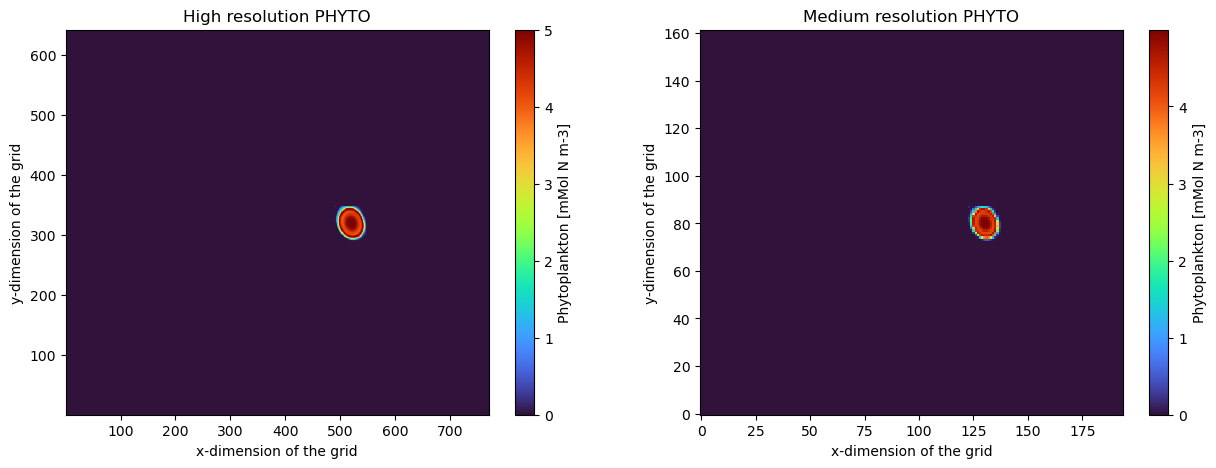

High resolution NO3 max: 10.0
Medium resolution NO3 max: 9.990636229515076
High resolution NO3 min: 0.5
Medium resolution NO3 min: 0.5


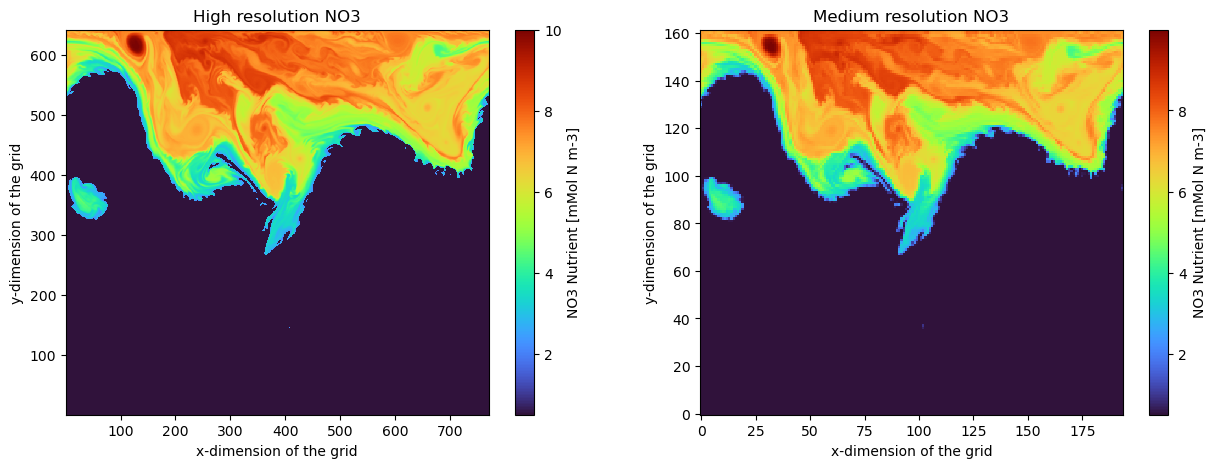

In [51]:
for var in ['PHYTO', 'NO3']:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    config1_bio[var][-1, -1].plot(ax=ax[0], cmap='turbo')
    config1_bio_medres[var][-1, -1].plot(ax=ax[1], cmap='turbo')
    ax[0].set_title(f"High resolution {var}")
    ax[1].set_title(f"Medium resolution {var}")
    print(f"High resolution {var} max: {config1_bio[var][-1, -1].max().values}")
    print(f"Medium resolution {var} max: {config1_bio_medres[var][-1, -1].max().values}")
    print(f"High resolution {var} min: {config1_bio[var][-1, -1].min().values}")
    print(f"Medium resolution {var} min: {config1_bio_medres[var][-1, -1].min().values}")
    plt.show()
    

Text(0.5, 1.0, 'Medium resolution hbl')

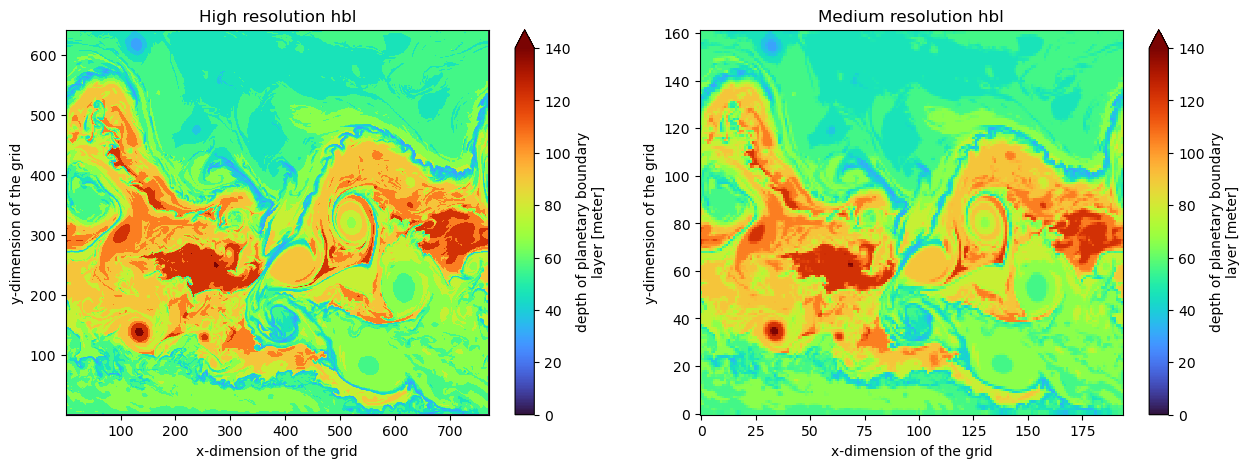

In [52]:
var='hbl'
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
config1_bio[var][-1].plot(ax=ax[0], cmap='turbo', vmin=0, vmax=140)
config1_bio_medres[var][-1].plot(ax=ax[1], cmap='turbo', vmin=0, vmax=140)
ax[0].set_title(f"High resolution {var}")
ax[1].set_title(f"Medium resolution {var}")

High resolution temp max: 14.257574737960056
Medium resolution temp max: 14.240476971602732
High resolution temp min: 12.368319889921095
Medium resolution temp min: 12.369434983523632
High resolution salt max: 34.054092078868614
Medium resolution salt max: 34.05308655835927
High resolution salt min: 34.0009774664473
Medium resolution salt min: 34.00102718815008


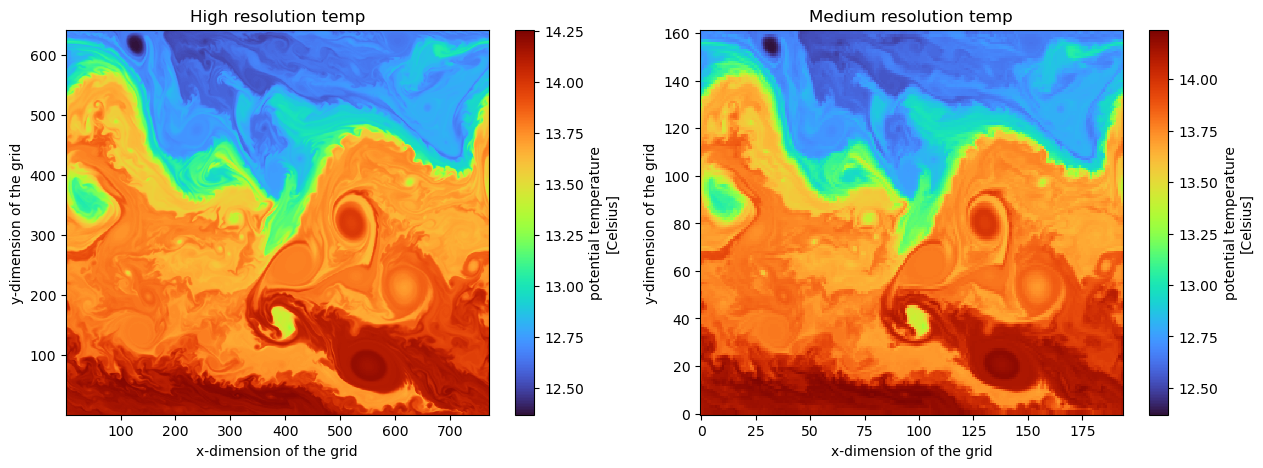

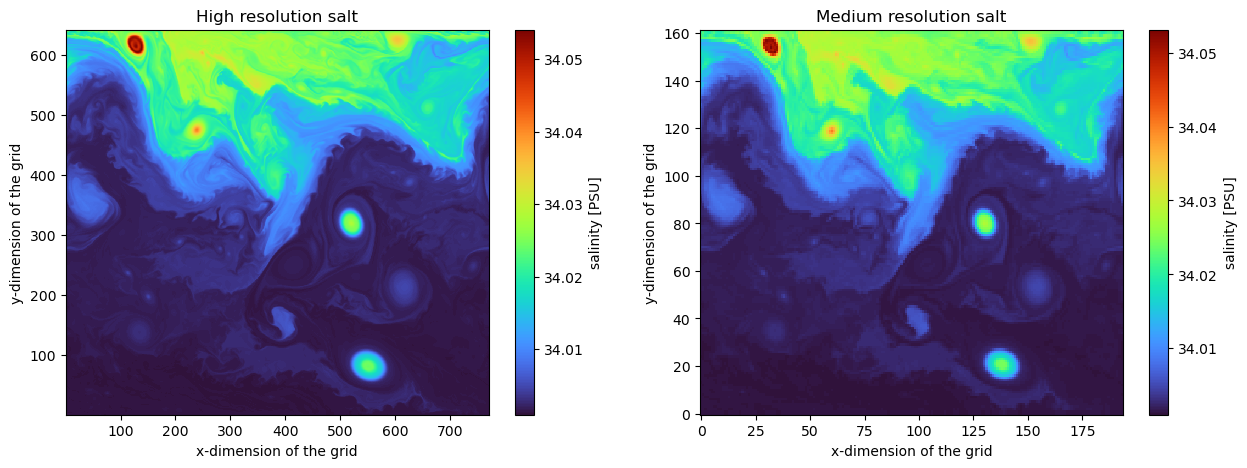

In [55]:
for var in ['temp', 'salt']:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    config1_bio[var][-1, -1].plot(ax=ax[0], cmap='turbo')
    config1_bio_medres[var][-1, -1].plot(ax=ax[1], cmap='turbo')
    ax[0].set_title(f"High resolution {var}")
    ax[1].set_title(f"Medium resolution {var}")
    print(f"High resolution {var} max: {config1_bio[var][-1, -1].max().values}")
    print(f"Medium resolution {var} max: {config1_bio_medres[var][-1, -1].max().values}")
    print(f"High resolution {var} min: {config1_bio[var][-1, -1].min().values}")
    print(f"Medium resolution {var} min: {config1_bio_medres[var][-1, -1].min().values}")
    plt.savefig(f'Figs/{var}.png')

In [53]:
#save
config1_bio_medres.to_netcdf('medres_bio_rst.nc')

In [24]:
config1.lon_u.max().values, config1.lon_u.min().values


(array(-165.37555), array(-174.99373))

In [23]:
config1 = xr.open_dataset('hires/hires_bio_rst.nc')
config1.lon_rho.max().values, config1.lon_rho.min().values


(array(-165.36928), array(-174.98746))

In [60]:
ls

dependencies/  inputs/  metadata.yaml  outputs/  param.h  subtests/


In [61]:
# see if grids match
config1_rst = xr.open_dataset('inputs/input_rst.nc')
config1_grid = xr.open_dataset('inputs/input_grd.nc')

In [69]:
def plot_grid(coarse_grid, m=4, n=4, alpha=1, color='r', linewidth=1.2, s=64, show_ghost_points=False):
    """
    Plot fine and coarse grids with their respective points using line segments for efficiency.

    Parameters:
    - hires_grid: The high-resolution grid data.
    - coarse_grid: The coarsened grid data.
    - m: Number of rows in the subgrid.
    - n: Number of columns in the subgrid.
    - alpha: Transparency level for the fine grid.
    - show_ghost_points: Whether to show ghost points.
    """

    # Extract coarse grid coordinates
    lonr, latr = coarse_grid['lon_rho'].values, coarse_grid['lat_rho'].values
    Lonu, Lonv, _ = rho2uvp(lonr)
    Latu, Latv, _ = rho2uvp(latr)

    # Extract subgrid range
    k = int(not show_ghost_points)  # Exclude ghost points if needed
    Lonr, Latr = lonr[k:m+1, k:n+1], latr[k:m+1, k:n+1]
    Lonu, Latu = Lonu[k:m+1, k:n+1], Latu[k:m+1, k:n+1]  # Align dimensions
    Lonv, Latv = Lonv[k:m+1, k:n+1], Latv[k:m+1, k:n+1]  # Align dimensions


    # Function to plot gridlines
    def plot_grid_lines(lon, lat, color, alpha=1.0, linewidth=1.0, zorder=1):
        # Horizontal lines
        for i in range(lat.shape[0]):
            plt.plot(lon[i, :], lat[i, :], color=color, alpha=alpha, linewidth=linewidth, zorder=zorder)
        # Vertical lines
        for j in range(lon.shape[1]):
            plt.plot(lon[:, j], lat[:, j], color=color, alpha=alpha, linewidth=linewidth, zorder=zorder)


    # Plot coarse grid lines
    if Lonu.shape == Latv.shape:
        plot_grid_lines(Lonu, Latv, color=color, alpha=alpha, linewidth=linewidth, zorder=1)
    else:
        plot_grid_lines(Lonu[:-1], Latv[:,:-1], color=color, alpha=alpha, linewidth=linewidth, zorder=1)

    # Scatter plots for points (set higher zorder to appear on top of lines)
    plt.scatter(Lonr, Latr, marker="x", color=color, s=s, zorder=3)
    plt.scatter(Lonu, Latu, marker=r"$\rightarrow$", s=s, color='k', zorder=3)
    plt.scatter(Lonv, Latv, marker=r"$\uparrow$", s=s, color='k', zorder=3)
    
def rho2uvp(grid):
    """Convert rho points to u, v, and psi points."""
    u = 0.5 * (grid[:, 1:] + grid[:, :-1])  # Average in the xi-direction (columns)
    v = 0.5 * (grid[1:, :] + grid[:-1, :])  # Average in the eta-direction (rows)
    p = 0.5 * (u[1:, :] + u[:-1, :])  # Average of u in the eta-direction (rows)
    return u, v, p

In [76]:
medres_rst = xr.open_dataset('medres/medres_bio_rst.nc')
medres_grid = xr.open_dataset('medres/generated_medres_bio_grd.nc')

In [78]:
hires_bio_rst = xr.open_dataset('hires/hires_bio_rst.nc')
hires_bio_grd = xr.open_dataset('hires/hires_bio_grd.nc')


In [93]:
#take all lon values from the medres grid and put them in the rst file
medres_rst['lon_rho'] = medres_grid['lon_rho']
medres_rst['lat_rho'] = medres_grid['lat_rho']
medres_rst['lon_u'] = medres_grid['lon_u']
medres_rst['lat_u'] = medres_grid['lat_u']
medres_rst['lon_v'] = medres_grid['lon_v']
medres_rst['lat_v'] = medres_grid['lat_v']

#save the new rst file
medres_rst.to_netcdf('medres/medres_bio_rst.nc')


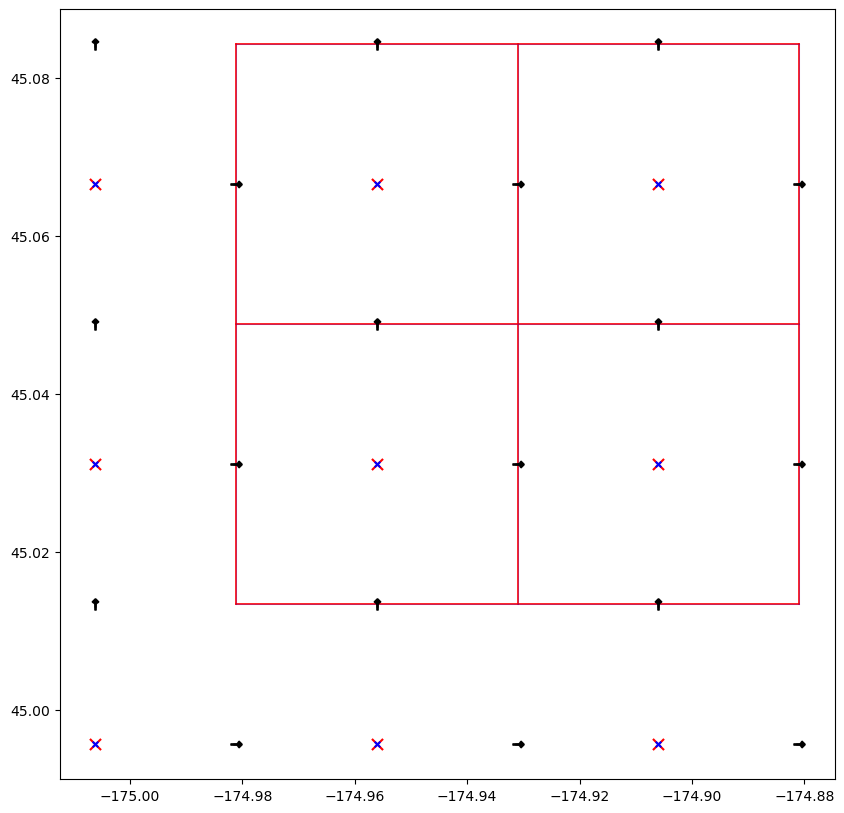

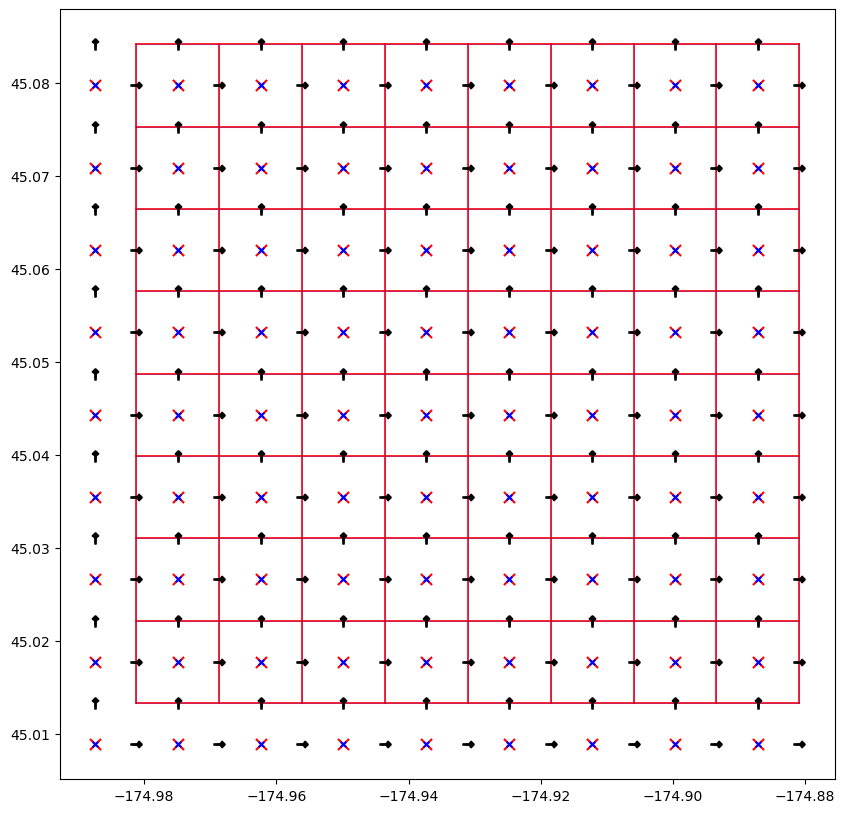

In [95]:
plt.figure(figsize=(10, 10))
plot_grid(medres_rst, m=3, n=3)
plot_grid(medres_grid, color='b', m=3, n=3, alpha=0.2, linewidth=0.8, s=16)

plt.figure(figsize=(10, 10))
plot_grid(hires_bio_rst, m=9, n=9)
plot_grid(hires_bio_grd, color='b', m=9, n=9, alpha=0.2, linewidth=0.8, s=16)


